In [41]:
import pandas as pd
import os

# 1. Get the current location of your notebook
current_path = os.getcwd()

data_path = os.path.join(current_path, '..', 'data', 'household_power_consumption.txt')

try:
    df = pd.read_csv(data_path, sep=';', low_memory=False, na_values=['nan','?'])
    print(f"✅ Success! Loaded data") 
    print(df.head())
except FileNotFoundError:
    print(f"❌ Still can't find it. Python is looking here: {os.path.abspath(data_path)}")

✅ Success! Loaded data
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


In [42]:
import pandas as pd
import numpy as np
import os

# 1. Setup the relative path to go UP from 'notebooks' and DOWN into 'data'
current_path = os.getcwd()
data_path = os.path.join(current_path, '..', 'data', 'household_power_consumption.txt')

# 2. Load the data using the path we just built
df = pd.read_csv(data_path, sep=';', 
                low_memory=False, 
                na_values=['nan','?'])

# 3. Combine Date and Time and fix the 'dayfirst' warning
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# 4. Set the index and drop old columns
df.set_index('dt', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# 5. Handle missing values and resample to Hourly frequency
# We use linear interpolation followed by hourly mean resampling
df = df.astype('float32').interpolate(method='linear')
df_hourly = df.resample('h').mean()

print(f"✅ Success! Data loaded and resampled")# from: {data_path}")
print(f"Cleaned dataset shape: {df_hourly.shape}")

✅ Success! Data loaded and resampled
Cleaned dataset shape: (34589, 7)


In [43]:
def create_forecasting_features(df):
    df = df.copy()
    
    # 1. Temporal Features (Captures cycles)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # 2. Lag Features (Gives the model historical memory)
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_24'] = df['Global_active_power'].shift(24)
    
    # 3. Rolling Mean (Smoothes out short-term spikes)
    df['rolling_mean_6'] = df['Global_active_power'].rolling(window=6).mean()
    
    # Drop rows with NaN (created by shifting/rolling)
    df = df.dropna()
    
    # This keeps the model focused and speeds up training on your CPU
    keep_columns = [
        'Global_active_power', 'hour', 'day_of_week', 'month', 
        'lag_1', 'lag_24', 'rolling_mean_6'
    ]
    
    return df[keep_columns]

# Apply the features
df_final = create_forecasting_features(df_hourly)

print(f"✅ Features engineered successfully! Shape: {df_final.shape}")
print(f"Columns used for training: {list(df_final.columns)}")
df_final.head()

✅ Features engineered successfully! Shape: (34565, 7)
Columns used for training: ['Global_active_power', 'hour', 'day_of_week', 'month', 'lag_1', 'lag_24', 'rolling_mean_6']


,Global_active_power,hour,day_of_week,month,lag_1,lag_24,rolling_mean_6
dt,,,,,,,
2006-12-17 17:00:00,3.406767,17,6,12,3.326033,4.222889,2.564578
2006-12-17 18:00:00,3.697100,18,6,12,3.406767,3.632200,2.861450
2006-12-17 19:00:00,2.908400,19,6,12,3.697100,3.400233,3.069389
2006-12-17 20:00:00,3.361500,20,6,12,2.908400,3.268567,3.280867
2006-12-17 21:00:00,3.040767,21,6,12,3.361500,3.056467,3.290094


In [44]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize the Scaler
# LSTMs are sensitive to scale; 0-1 range helps the model converge faster
scaler = MinMaxScaler(feature_range=(0, 1))

# 2. Scale all features (Global_active_power, Lags, Temporal features, etc.)
# scaled_data = scaler.fit_transform(df_features)
# # Change df_features to df_final
scaled_data = scaler.fit_transform(df_final)
# 3. Create the Sliding Window sequences
def create_sequences(data, n_past=72, n_future=24):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        # X: The past 72 hours (3 days) of data to learn patterns
        X.append(data[i - n_past:i, :])
        
        # y: The next 24 hours (1 day) of 'Global_active_power' to predict
        # Index 0 is used because 'Global_active_power' is our first column
        y.append(data[i:i + n_future, 0])
        
    return np.array(X), np.array(y)

# Generate the sequences
X, y = create_sequences(scaled_data)

print(f"✅ Sequences Created!")
print(f"X shape (Samples, 72 hours, 11 features): {X.shape}")
print(f"y shape (Samples, 24 hours prediction): {y.shape}")

✅ Sequences Created!
X shape (Samples, 72 hours, 11 features): (34470, 72, 7)
y shape (Samples, 24 hours prediction): (34470, 24)


In [45]:
# 1. Total records is just the length of your DataFrame
total_records = len(df)

# 2. Calculate the number of days
# Since the data is minute-by-minute, we divide by (60 minutes * 24 hours)
total_days = total_records / (60 * 24)

# 3. Get the exact date range
first_date = df.index.min()
last_date = df.index.max()

print(f"📊 Total Recordss (Minutes): {total_records:,}")
print(f"📅 Total Days of Data: {total_days:.2f} days (approx {total_days/365:.1f} years)")
print(f"🗓️ Date Range: From {first_date.date()} to {last_date.date()}")

📊 Total Recordss (Minutes): 2,075,259
📅 Total Days of Data: 1441.15 days (approx 3.9 years)
🗓️ Date Range: From 2006-12-16 to 2010-11-26


In [46]:
# 1. Calculate split points for 70/15/15 split
n_total = len(X)
train_end = int(n_total * 0.70)
val_end = int(n_total * 0.85)

# 2. Split the data chronologically (No Shuffling!)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# 3. Final Verification for the Questionnaire
print("--- Data Split Summary ---")
print(f"✅ Training set:   {X_train.shape[0]} samples (Past)")
print(f"✅ Validation set: {X_val.shape[0]} samples (Middle)")
print(f"✅ Test set:       {X_test.shape[0]} samples (Future/Final)")
print("-" * 26)
print(f"📊 Input shape: {X_train.shape} (Samples, 72 hours, 11 features)")

--- Data Split Summary ---
✅ Training set:   24129 samples (Past)
✅ Validation set: 5170 samples (Middle)
✅ Test set:       5171 samples (Future/Final)
--------------------------
📊 Input shape: (24129, 72, 7) (Samples, 72 hours, 11 features)


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. Stacked LSTM Architecture
# We use 50 units then 30 units to extract hierarchical temporal patterns
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=True), 
    Dropout(0.3),                          
    LSTM(units=30, return_sequences=False),
    Dropout(0.3),
    Dense(units=24)                        
])

# 2. Compile with Adam Optimizer
# A learning rate of 0.0005 provides a good balance between speed and stability
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# 3. Setup Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the Model
print("🚀 Starting training on CPU...")
history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=32,                         
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

🚀 Starting training on CPU...
Epoch 1/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 0.0206 - mae: 0.1089 - val_loss: 0.0163 - val_mae: 0.1032
Epoch 2/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - loss: 0.0163 - mae: 0.0971 - val_loss: 0.0127 - val_mae: 0.0862
Epoch 3/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 63s 57ms/step - loss: 0.0144 - mae: 0.0895 - val_loss: 0.0123 - val_mae: 0.0849
Epoch 4/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - loss: 0.0140 - mae: 0.0877 - val_loss: 0.0122 - val_mae: 0.0829
Epoch 5/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0136 - mae: 0.0865 - val_loss: 0.0124 - val_mae: 0.0848
Epoch 6/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - loss: 0.0134 - mae: 0.0858 - val_loss: 0.0119 - val_mae: 0.0819
Epoch 7/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0132 - mae: 0.0848 - val_loss: 0.0115 - val_mae: 0.0811
Epoch 8/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0129 - mae: 0.0839 - val_loss: 0.0117 - val_mae: 0.0803
Epoch 9/50

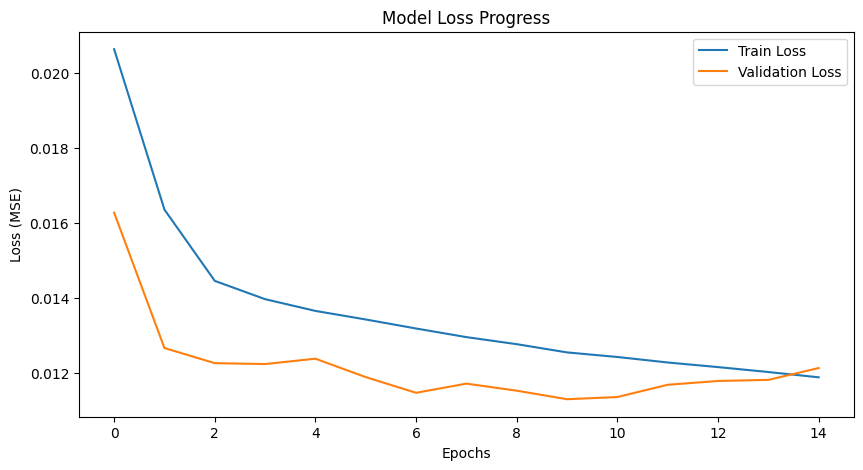

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [49]:
# 1. Generate forecasts on the test set

predictions = model.predict(X_test)

# 2. Inverse Transform (Requirement: "Back to original scale")
# Manual inverse scaling using Global_active_power (column index 0) constants
p_min = scaler.data_min_[0]
p_max = scaler.data_max_[0]

predictions_kw = (predictions * (p_max - p_min)) + p_min
y_test_kw = (y_test * (p_max - p_min)) + p_min

print("✅ Predictions converted back to original units (kW).")

162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
✅ Predictions converted back to original units (kW).


In [50]:
# 3. Calculate Final Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# We compare the first hour of each forecast for standard evaluation
mae = mean_absolute_error(y_test_kw[:, 0], predictions_kw[:, 0])
rmse = np.sqrt(mean_squared_error(y_test_kw[:, 0], predictions_kw[:, 0]))
mape = np.mean(np.abs((y_test_kw[:, 0] - predictions_kw[:, 0]) / y_test_kw[:, 0])) * 100

print(f"📊 Mean Absolute Error (MAE): {mae:.4f} kW")
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f} kW")
print(f"📊 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

📊 Mean Absolute Error (MAE): 0.4129 kW
📊 Root Mean Squared Error (RMSE): 0.5612 kW
📊 Mean Absolute Percentage Error (MAPE): 57.96%


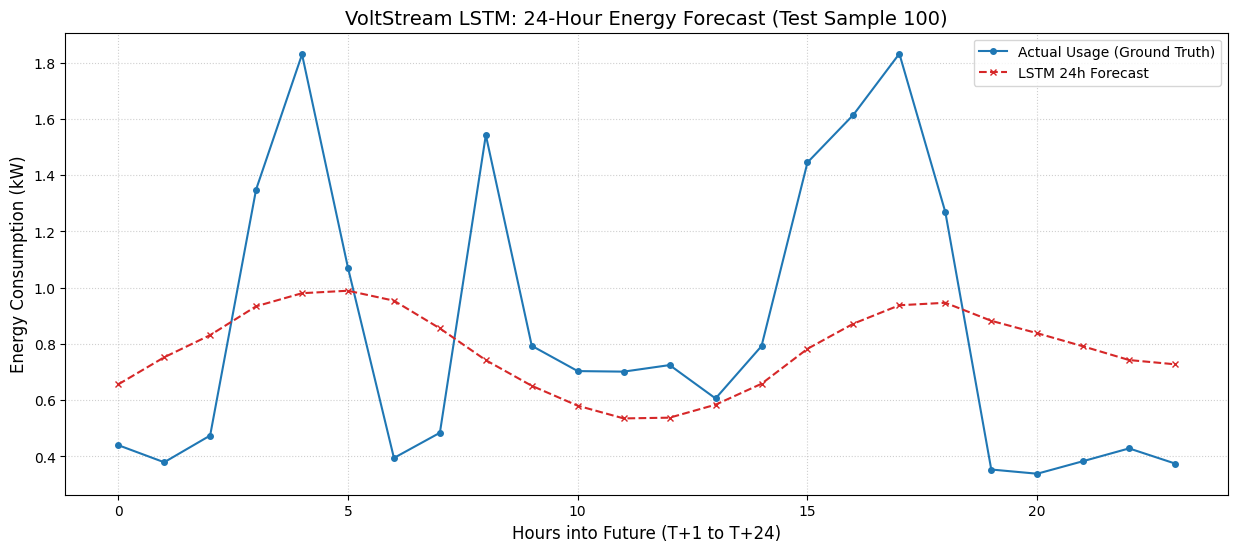

In [51]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 6))

sample_idx = 100 

plt.plot(y_test_kw[sample_idx], label='Actual Usage (Ground Truth)', color='#1f77b4', marker='o', markersize=4)
plt.plot(predictions_kw[sample_idx], label='LSTM 24h Forecast', color='#d62728', linestyle='--', marker='x', markersize=4)

plt.title(f'VoltStream LSTM: 24-Hour Energy Forecast (Test Sample {sample_idx})', fontsize=14)
plt.xlabel('Hours into Future (T+1 to T+24)', fontsize=12)
plt.ylabel('Energy Consumption (kW)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Calculate official metrics on the real-world kW scale
# This evaluates all 24 hours of the forecast horizon across the entire test set
mae = mean_absolute_error(y_test_kw, predictions_kw)
rmse = np.sqrt(mean_squared_error(y_test_kw, predictions_kw))

# 2. MAPE (Mean Absolute Percentage Error) 
# Adding 1e-10 prevents 'division by zero' errors if energy usage was ever exactly 0
mape = np.mean(np.abs((y_test_kw - predictions_kw) / (y_test_kw + 1e-10))) * 100

# 3. Calculate an overall Accuracy score (100 - MAPE)
accuracy = 100 - mape

print(f"📊 --- FINAL PERFORMANCE METRICS ---")
print(f"✅ Mean Absolute Error (MAE):    {mae:.4f} kW")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f} kW")
print(f"✅ Mean Absolute % Error (MAPE):   {mape:.2f}%")
print(f"⭐ Overall Model Accuracy:        {accuracy:.2f}%")

📊 --- FINAL PERFORMANCE METRICS ---
✅ Mean Absolute Error (MAE):    0.4385 kW
✅ Root Mean Squared Error (RMSE): 0.5898 kW
✅ Mean Absolute % Error (MAPE):   64.20%
⭐ Overall Model Accuracy:        35.80%


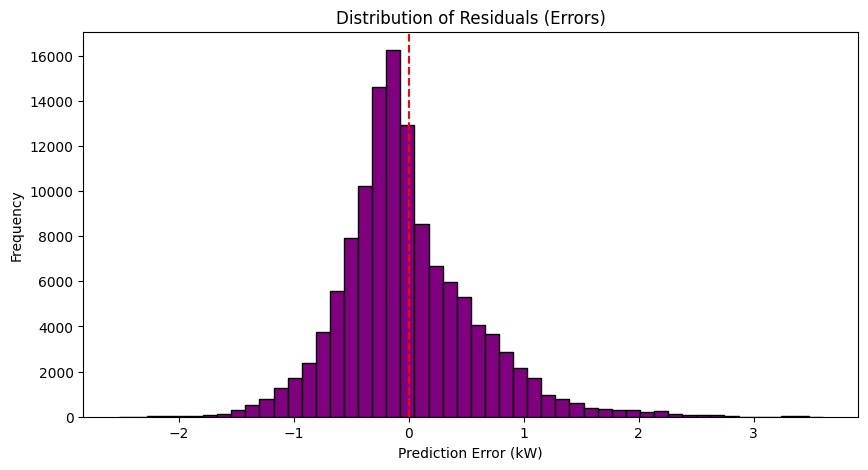

In [53]:
# Calculate residuals
residuals = y_test_kw - predictions_kw

plt.figure(figsize=(10, 5))
plt.hist(residuals.flatten(), bins=50, color='purple', edgecolor='black')
plt.title('Distribution of Residuals (Errors)')
plt.xlabel('Prediction Error (kW)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--') # Red line at zero error
plt.show()

In [54]:
import os

# 1. Define the path to the 'models' folder

model_dir = os.path.join('..', 'models')

# 2. Create the folder if it doesn't exist yet
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 3. Save the model with the correct path
model_save_path = os.path.join(model_dir, 'voltstream_energy_model.keras')
model.save(model_save_path)

print(f"✅ Success! Model saved in the models folder at: {model_save_path}")

✅ Success! Model saved in the models folder at: ..\models\voltstream_energy_model.keras


### downlaod the model using the below link

In [58]:
from IPython.display import FileLink
import os

model_path = os.path.join('..', 'models', 'voltstream_energy_model.keras')

if os.path.exists(model_path):
    display(FileLink(model_path))
else:
    print(f"❌ Error: Model not found at {model_path}")
    print("Check your 'models' folder in the VS Code sidebar!")

c:\Gpp-Tasks\week-10\VoltStream-LSTM\models\voltstream_energy_model.keras